## 例4-1. Pythonで，Yelpのレビューデータを読み込んでクリーニング

In [6]:
import json
import pandas as pd

# Yelpのビジネスデータを読み込み
with open('../data/yelp_academic_dataset_business.json') as biz_f:
    biz_df = pd.DataFrame([json.loads(x) for x in biz_f.readlines()])

# Yelpのレビューデータを読み込み
with open('../data/yelp_academic_dataset_review.json') as review_file:
    review_df = pd.DataFrame([json.loads(x) for x in review_file.readlines()])

# YelpのビジネスデータからcategoriesがNightlife（ナイトライフ@<fn>{nightlife}）またはRestaurants(レストラン)のデータを取り出し
filter_func = lambda x:  len(set(x) &  set(['Nightlife', 'Restaurants'])) > 0
twobiz = biz_df[biz_df['categories'].apply(filter_func)]

# 取り出した2つのカテゴリのYelpのビジネスデータとYelpのレビューデータを結合する
twobiz_reviews = twobiz.merge(review_df, on='business_id', how='inner')

# 必要ない特徴量を排除
twobiz_reviews = twobiz_reviews[['business_id', 'name', 'stars_y', 'text', 'categories']]

# target列を作成。categoriesがNightlifeの時はTrue、それ以外の場合はFalse
twobiz_reviews['target'] =  twobiz_reviews['categories'].apply(set(['Nightlife']).issubset)

twobiz

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
5,ShUDf64NVkwCe8izdUbYuw,"5820 W McDowell Rd\nPhoenix, AZ 85035","{'Monday': {'close': '06:00', 'open': '06:00'}...",True,"[Mexican, Restaurants]",Phoenix,3,Los Armandos Asadero Y Mariscos,[],-112.184772,AZ,5.0,33.466373,"{'Good for Kids': True, 'Alcohol': 'full_bar',...",business
7,mQfT3JYu18HN22DVylcE7A,"3134 E Indian School Rd\nPhoenix, AZ 85018","{'Monday': {'close': '15:30', 'open': '07:30'}...",True,"[Bakeries, Food, Breakfast & Brunch, Sandwiche...",Phoenix,177,Bertha's Café,[],-112.014454,AZ,4.5,33.495216,"{'Take-out': True, 'Wi-Fi': 'no', 'Good For': ...",business
11,MiVcQsXp3TYUmeD7FSa-hA,"21 W Main St\nMesa, AZ 85201","{'Monday': {'close': '16:00', 'open': '08:00'}...",True,"[Bakeries, Food, Sandwiches, Restaurants]",Mesa,70,Sweet Cakes Café,[],-111.832185,AZ,3.5,33.414840,"{'Take-out': True, 'Wi-Fi': 'free', 'Good For'...",business
15,_IwgdSjrIMwAcQdeLNhcZQ,Talking Stick Resort\n9800 E Indian Bend Rd\nS...,{},True,"[Bars, Nightlife]",Scottsdale,14,Shadows,[],-111.821087,AZ,4.0,33.501360,"{'Price Range': 3, 'Alcohol': 'full_bar', 'Goo...",business
18,tl9XIP5trlkcuSfTQqe5jg,"632 N Estrella Pkwy\nGoodyear, AZ 85338",{},True,"[Fast Food, Restaurants]",Goodyear,6,McDonalds,[],-112.393195,AZ,2.0,33.453887,"{'Take-out': True, 'Wi-Fi': 'free', 'Drive-Thr...",business
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15573,qZCtzJCdt29_DdYD8US9FQ,14700 N Frank Lloyd Wright Blvd\nSte 159\nScot...,"{'Monday': {'close': '21:00', 'open': '11:00'}...",False,"[Italian, Pizza, Restaurants]",Scottsdale,9,New York 51 Pizzeria,[],-111.874248,AZ,2.5,33.619514,"{'Take-out': True, 'Wi-Fi': 'free', 'Good For'...",business
15577,-1bOb2izeJBZjHC7NWxiPA,"61 W. Thomas Road\nPhoenix, AZ 85013","{'Monday': {'close': '14:30', 'open': '07:00'}...",True,"[Breakfast & Brunch, Cafes, American (Traditio...",Phoenix,75,First Watch,[],-112.077144,AZ,3.5,33.479996,"{'Alcohol': 'none', 'Noise Level': 'average', ...",business
15579,SgTjnyElc26gPUghVuCuSQ,"4723 E Ray Rd\nPhoenix, AZ 85044","{'Monday': {'close': '23:00', 'open': '11:00'}...",True,"[American (Traditional), Restaurants]",Phoenix,57,Keegan's Grill & Taproom Foothills,[],-111.981797,AZ,4.0,33.319269,"{'Take-out': True, 'Wi-Fi': 'free', 'Good For'...",business
15580,gfSNqTICrdeewK8XINGSaA,"1909 E Ray Rd\nChandler, AZ 85225","{'Tuesday': {'close': '14:30', 'open': '11:30'...",True,"[Sushi Bars, Japanese, Restaurants]",Chandler,83,Taiko,[],-111.809582,AZ,4.0,33.319907,"{'Take-out': True, 'Wi-Fi': 'no', 'Good For': ...",business


## 例4-2. クラス均衡のとれた分類用データセットの作成

In [7]:
from sklearn.model_selection import train_test_split

# サンプリングしてクラス均衡を是正したデータセットを作成
nightlife = twobiz_reviews[twobiz_reviews['categories'].apply(set(['Nightlife']).issubset)]
restaurants = twobiz_reviews[twobiz_reviews['categories'].apply(set(['Restaurants']).issubset)]

nightlife_subset = nightlife.sample(frac=0.1, random_state=123)
restaurant_subset = restaurants.sample(frac=0.021, random_state=123)
combined = pd.concat([nightlife_subset, restaurant_subset])

# 学習データとテストデータに分割
training_data, test_data = train_test_split(combined, test_size=0.3, random_state=123)
training_data.shape

(4456, 6)

## 例4-3. 特徴量の変換

In [8]:
from sklearn.feature_extraction import text

# レビューをBag-of-Wordsで表す
bow_transform = text.CountVectorizer()
X_tr_bow = bow_transform.fit_transform(training_data['text'])
X_te_bow = bow_transform.transform(test_data['text'])
len(bow_transform.vocabulary_)

18747

In [9]:
from sklearn.preprocessing import normalize

y_tr = training_data['target']
y_te = test_data['target']

# Bag-of-Words行列からTF-IDFを作成
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_trfm.transform(X_te_bow)

#  Bag-of-WordsのL2正規化
X_tr_l2 = normalize(X_tr_bow, norm='l2', axis=0)
X_te_l2 = normalize(X_te_bow, norm='l2', axis=0)

## 例4-4. ロジスティック回帰

In [10]:
from sklearn.linear_model import LogisticRegression

def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
### ロジスティック回帰で学習し、テストデータでの予測結果を得る関数
    m = LogisticRegression(solver='liblinear', C=_C).fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with bow features: 0.7530088958660387
Test score with l2-normalized features: 0.7645211930926217
Test score with tf-idf features: 0.7352171637885924


## 例4-5. ロジスティック回帰のハイパーパラメータをグリッドサーチでチューニング

In [13]:
from sklearn.model_selection import GridSearchCV

# 探索範囲を指定して、5分割でグリッドサーチを実行します
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

# Bag-of-Wordsでの分類器をチューニング
bow_search = GridSearchCV(LogisticRegression(solver='liblinear'), cv=5, param_grid=param_grid_, return_train_score=True)
bow_search.fit(X_tr_bow, y_tr)

# L2正規化単語ベクトルでの分類器をチューニング
l2_search = GridSearchCV(LogisticRegression(solver='liblinear'), cv=5, param_grid=param_grid_, return_train_score=True)
l2_search.fit(X_tr_l2, y_tr)

# TF-IDFでの分類器をチューニング
tfidf_search = GridSearchCV(LogisticRegression(solver='liblinear'), cv=5, param_grid=param_grid_, return_train_score=True)
tfidf_search.fit(X_tr_tfidf, y_tr)

# グリッドサーチにおける出力を見て、挙動を確認します
bow_search.cv_results_

{'mean_fit_time': array([0.10681396, 0.18409643, 0.39129806, 0.64468884, 0.95523267,
        1.17362537]),
 'std_fit_time': array([0.03508347, 0.04502447, 0.11875427, 0.21049969, 0.12343812,
        0.17142388]),
 'mean_score_time': array([0.0051003 , 0.00365438, 0.00229735, 0.00222907, 0.00236697,
        0.00213041]),
 'std_score_time': array([0.0022572 , 0.00301311, 0.00024537, 0.00056091, 0.00055814,
        0.00022064]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.56726457, 0.71860987, 0.77802691, 0.76345291, 0.7455157 ,
        0.73318386]),
 'split1_test_score': array([0.5667789 , 0.70145903, 0.78002245, 0.75757576, 0.73849607,
        0.73063973]),
 'split2_test_score': array([0.56565657, 0.7037037 , 0.7609427

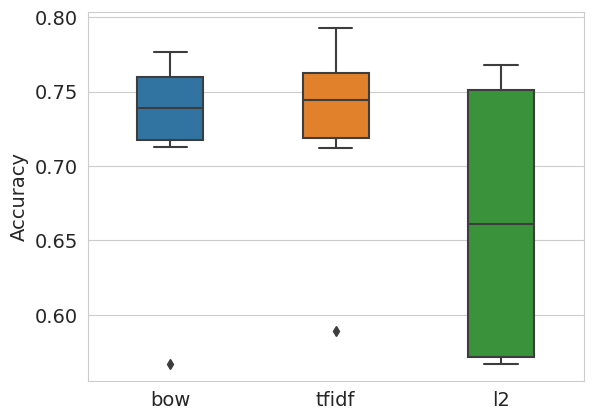

In [14]:
# クロスバリデーションの結果を箱ひげ図でプロットする
# 分類器のパフォーマンスを可視化して比較する
search_results = pd.DataFrame.from_dict({
    'bow': bow_search.cv_results_['mean_test_score'],
    'tfidf': tfidf_search.cv_results_['mean_test_score'],
    'l2': l2_search.cv_results_['mean_test_score']
})

# matplotlibでグラフを描く。ここでSeabornはグラフの見た目を整える為に用いている。
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)